In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn
from src.assoc_utils_np import train_gcpc
from src.assoc_utils_np_2D import gen_gbook_2d, path_integration_Wgg_2d, module_wise_NN_2d
from src.seq_utils import *

from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

In [2]:
import scipy.io 
mat = scipy.io.loadmat('pos60by60.mat')
mat = scipy.io.loadmat('pos420by420.mat')
#mat = scipy.io.loadmat('pos585by585.mat')
hexgbook_map = mat["newpos"]

In [3]:
nruns=1
Np = 400  #300 #500 #500 #500 #400
lambdas = [3,4,5,7] #[3,4,5,7] #[2,3,5] #[4,5,7] #[3,4,5] #[5,9,13] #[3,4,5] #[3,4,5] 
Ng = np.sum(np.square(lambdas))
Npos = np.prod(lambdas)
gbook = gen_gbook_2d(lambdas, Ng, Npos)
gbook.shape     # (Ng, Npos, Npos)

module_sizes = np.square(lambdas)
module_gbooks = [np.eye(i) for i in module_sizes]

Wpg = randn(nruns, Np, Ng) 

In [4]:
from numpy.random import randint
    
Npatts=Npos*Npos

gbook_flattened = gbook.reshape(Ng, Npos*Npos)
Wpg = randn(nruns, Np, Ng) #/ (np.sqrt(M));                      # fixed random gc-to-pc weights
c = 0.60     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)

thresh = 2#0.5 
pbook = nonlin(np.einsum('ijk,klm->ijlm', Wpg, gbook), thresh=thresh)  # (nruns, Np, Npos, Npos) 

gbook_flattened = gbook.reshape(Ng, Npos*Npos)  #order='F'
pbook_flattened = pbook.reshape(nruns, Np, Npos*Npos)
Wgp = train_gcpc(pbook_flattened, gbook_flattened,Npatts)


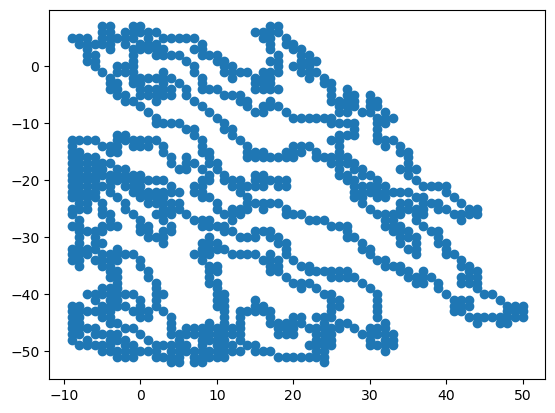

In [5]:
#data = np.load("paths/self_intersecting/60_by_60_len_1000_100_intersections.npy")
data = np.load("paths/xy_coords_1000_2.npy")
xcoord = data[0,:]
ycoord = data[1,:]

plt.figure()
plt.scatter(xcoord, ycoord)

path_locations = []
x_c = 10 #0 #0 #27 #10 #18 #50 #10 #0 
y_c = 58 #48 #55 #16 #45 #40 #40 #58 #21  
for i in range(len(xcoord)):
    path_locations.append((xcoord[i]+x_c, ycoord[i]+y_c))
    

In [6]:
Npatts = len(path_locations)
Ns = Npatts #3600
x, y = Npos, Npos # Npos, Npos
sbook = sens_nonlin(randn(Ns, x, y))
sbook_flattened = sbook.reshape(Ns, x*y)

In [7]:
sbookinv = np.linalg.pinv(sbook_flattened)
Wps = pbook_flattened[:,:,:Npos*Npos]@sbookinv
#Wps = np.squeeze(Wps)
Wps.shape

(1, 400, 1001)

In [8]:
abook = actions(path_locations)
path_pbook, path_sbook = path_codes(path_locations, pbook, sbook)  
#Wap = actionmap(abook, path_pbook)  #nruns, Na, Np
#Wap = actionmap(abook, path_PBOOK)  #nruns, Na, Np
Wsp = sensorymap(path_sbook, path_pbook)

In [9]:
# learn action mapping from place to actions through perceptron algorithm
n_run = 0
X = path_pbook[n_run].T
#X = new_input_X.T  #map from placestate and v(t-1) to actions
#X = np.sign(randn(Np, Npatts)).T   # map from random pbook patterns
y = abook.T
model = MLPClassifier(hidden_layer_sizes=(250), activation="relu", random_state=6, max_iter=12000).fit(X, y)
#500

#model = MLPClassifier(hidden_layer_sizes=(500,250,100), random_state=1, max_iter=10000).fit(X, y)
model.fit(X, y)


MLPClassifier(hidden_layer_sizes=250, max_iter=12000, random_state=6)

In [10]:
model.score(X,y)

1.0

In [11]:
# Predicting both P and S states
path_locations_flattened = [x*Npos+y for x, y in path_locations]


decoded_path_locations = []

n_run=0
k = 0
g = gbook_flattened[:,path_locations_flattened[0]] 
for i in path_locations_flattened: 
    #print(k, i)
    k+=1
    decoded_path_locations.append(gcode_to_coord(g[None,:,None], gbook_flattened, Npos))
    #decoded_path_locations.append(gcode_to_coord(g, gbook_flattened, Npos))

    error = np.sum(np.abs(g.flatten()-gbook_flattened[:,i]))
    #print("Error in G: ", error)
    
    #p = nonlin(Wpg@g, thresh) #relu(Wps@s) 
    #p = relu(Wps@sbook_flattened[:,i])

    # compute p using multiplicative interactions between sensory and grid inputs
    s = sbook_flattened[:,i]
    g = gbook_flattened[:,i]
    g_in = Wpg@g
    s_in = Wps@s
    p = np.sqrt(np.multiply(nonlin(g_in, thresh), relu(s_in)))
    
    

    gin = Wgp@p.T
    #gin = gin[:,:,None]
    g2 = module_wise_NN_2d(gin, module_gbooks, module_sizes)
    p = nonlin(Wpg@g2, thresh)   #nonlin(Wpg@g)
    #p = np.sqrt(np.multiply(nonlin(Wpg@g2, thresh), relu(s_in)))
    p = p[:,:,0]
    
    error = np.linalg.norm(g-g2[0,:,0])/(Ng)            # continuous p
    #print("Error in two g's: ", error)
    

    #error = np.sum(np.abs(p[n_run].flatten()-pbook_flattened[n_run,:,i]))/(2*Np)   # binary p
    error = np.linalg.norm(p[n_run].flatten()-pbook_flattened[n_run,:,i])/(Np)            # continuous p
    #print("Error in P: ", error)
    
    s = np.sign(Wsp@p[:,:,None])
    #print("Error in S: ", np.linalg.norm(s[n_run].flatten()-sbook_flattened[:,i])/(Ns))
    
    
    # for the sake of consistency. Could add g inputs from action and place code and normalize
#     gin = Wgp@p[n_run]
#     g_test = module_wise_NN_2d(gin[n_run][None,:,None], module_gbooks, module_sizes)  
#     error = np.sum(np.abs(g_test.flatten()-gbook[:,i,j]))
#     print("Error in G from P: ", error)
    
    a = model.predict(p[:1])
    #a = model.predict(X[k-1][None,:])     # perceptron mapping random patterns
    action = int(a[n_run])      # run0

    
    # 1d actions
    axis, direction = oneDaction_mapping(action)
    if axis == None:
        continue
    #print("Action: ", axis, direction)
    
    
    if isinstance(axis, list):
        Wgg = path_integration_Wgg_2d(lambdas, Ng, axis=axis[0], direction=direction[0])  
        g = Wgg@g
        Wgg = path_integration_Wgg_2d(lambdas, Ng, axis=axis[1], direction=direction[1])
        g = Wgg@g
    else:
        Wgg = path_integration_Wgg_2d(lambdas, Ng, axis=axis, direction=direction)
        g = Wgg@g
    g = np.squeeze(g)
    

C:\Users\chand\AppData\Local\Temp\ipykernel_53288\370504589.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter((hexgbook_map[0,:,:]+np.arange(Npos)//2), hexgbook_map[1,:,:], c='lightgrey', s=100, edgecolors="white", linewidths=0.1, cmap = 'Reds')


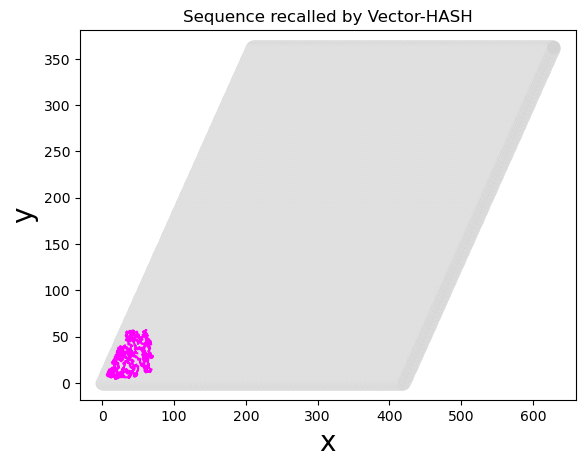

C:\Users\chand\AppData\Local\Temp\ipykernel_53288\370504589.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter((hexgbook_map[0,:,:]+np.arange(Npos)//2), hexgbook_map[1,:,:], c='lightgrey', s=100, edgecolors="white", linewidths=0.1, cmap = 'Reds')


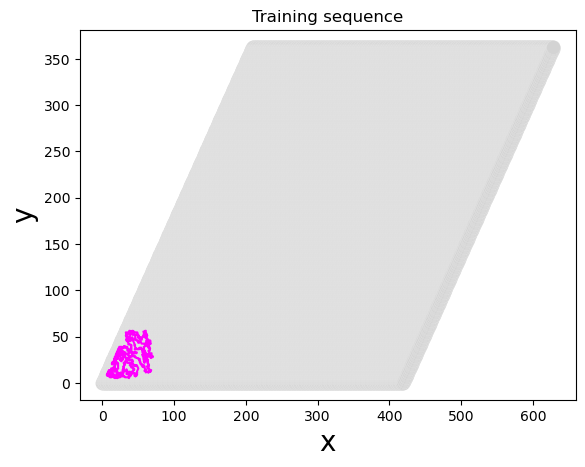

Npatts =  1001


In [12]:
plt.figure()
ax = plt.axes()

hex_path_locations = mapRealtoHex(hexgbook_map, decoded_path_locations)
plt.scatter((hexgbook_map[0,:,:]+np.arange(Npos)//2), hexgbook_map[1,:,:], c='lightgrey', s=100, edgecolors="white", linewidths=0.1, cmap = 'Reds')
plt.plot(*zip(*hex_path_locations), '-', color="magenta")
plt.ylabel("y", fontsize="20")
plt.xlabel("x", fontsize="20")
plt.title("Sequence recalled by Vector-HASH")
plt.show()

plt.figure()
ax = plt.axes()
hex_path_locations = mapRealtoHex(hexgbook_map, path_locations)
plt.scatter((hexgbook_map[0,:,:]+np.arange(Npos)//2), hexgbook_map[1,:,:], c='lightgrey', s=100, edgecolors="white", linewidths=0.1, cmap = 'Reds')
plt.plot(*zip(*hex_path_locations), '-', color="magenta")
#plt.plot(*hex_path_locations[0], 'd-', color="black")
plt.ylabel("y", fontsize="20")
plt.xlabel("x", fontsize="20")
plt.title("Training sequence")

plt.show()
print("Npatts = ", len(path_locations))